In [479]:
import pandas as pd
import numpy as np
from scipy.stats import weibull_min, invweibull, uniform, norm
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

# Create the P function from matlab
data = np.loadtxt("powermat.csv", delimiter=",")
x = np.arange(0,30,0.001)
P = interp1d(x,data, fill_value="extrapolate")

# Creating lambda function allowing faster calculations
calculate_power = lambda x: P(x)

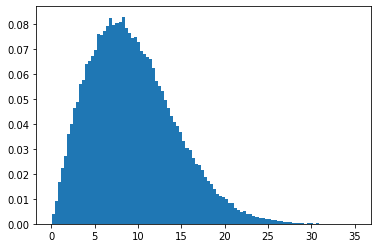

In [546]:
# Setting the parameters, this is for january
k = 2.0
lam = 10.6
n = 10**5

# Creating the wind distribution for a month
wind_distribution =  weibull_min(k,loc=0, scale=lam)

# Generate som wind
wind = wind_distribution.rvs(size=n)
_ = plt.hist(wind, bins=100, density=True)

Mean: 1729173.3689228164 ± 7608.380795675802, Var: 1506858036547.4895


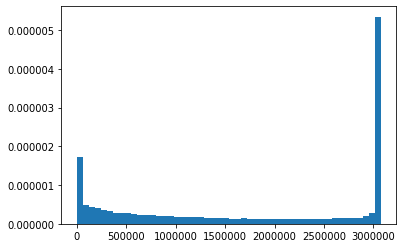

In [503]:
# A) Expected amount of power

# Calculated som power from the generated wind
power = calculate_power(wind)
hist = plt.hist(power, density=True, bins=50)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power)
var = np.var(power)
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')

Mean: 1729144.2349996031 ± 6612.308941761666, Var: 1138135921004.3022


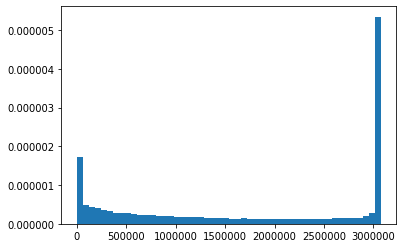

In [524]:
# A) Expected amount of power, truncated version

# Calculating F(3) and F(25) for the distribution for the wind
F_min = wind_distribution.cdf(3)
F_max = wind_distribution.cdf(25)

# Generate som uniform data, scaled to to F(3) and F(25):
u = uniform.rvs(loc = wind_distribution.cdf(3), scale = (F_max - F_min), size=n)

# Run u through inverse of weibull 
wind_truncated = wind_distribution.ppf(u)

# Calculated the power for the truncated wind
power_trunc = calculate_power(wind_truncated)
hist = plt.hist(power, density=True, bins=50)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power_trunc)*(F_max-F_min)
var = np.var(power_trunc)*((F_max-F_min)**2)
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')

Mean: 1722139.4070362607 ± 30.51462660038244, Var: 24238401.61809578


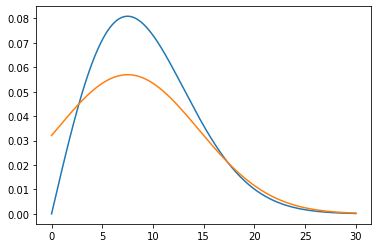

In [554]:
x = np.linspace(0,30, num=n)

# Selecting g as a normal distribution with my = 7.5 and sigma = 5
g_dist = norm(7.5, 7)

# Function to calculate for each drawn g
s = lambda x: P(x)*wind_distribution.pdf(x)/g_dist.pdf(x)

plt.plot(x,wind_distribution.pdf(x))
plt.plot(x, g_dist.pdf(x))
#plt.plot(x, s(x))

# Draw n samples from g
samples_from_g = g_dist.rvs(size=n)

# Calculated the weighted sample
weighted_samples = s(samples_from_g)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(weighted_samples)
var = np.var(weighted_samples)/n
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')